# **East Africa drought study - exploratory analysis**

In [2]:
source("../methods_extRemes.r")

## **Trends in ENSO/GMST/IOD/MJO**

In [35]:
df <- merge(merge(merge(merge(merge(merge(merge(merge(read.fwf("/home/clair/wwa/90_data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst")),
                                                      read.csv("data/nino3.4rel_mam.csv", col.names = c("year", "nino_mam"))),
                                                read.csv("data/nino3.4rel_ond.csv", col.names = c("year", "nino_ond"))),
                                          read.csv("ts/EA-drought_pr-mam_chirps05.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "mam"))),
                                    read.csv("ts/EA-drought_pr-ond_chirps05.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "ond"))),
                              read.csv("ts/EA-drought_pr12_chirps05.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "pr12"))),
                        read.csv("ts/EA-drought_pr24_chirps05.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "pr24")), all = T),
                  read.csv("data/iod_ond.csv"), all = T),
            read.csv("data/mjo_ond.csv"), all = T)
write.csv(df, "data/gmst-nino-rains.csv", row.names = F)

df["log_ond"] <- log10(df$ond)

write.csv(df, "data/gmst-nino-rains.csv", row.names = F)

In [36]:
df <- read.csv("data/gmst-nino-rains.csv")

lm_ond <- lm(ond ~ gmst + nino_ond, df)
lm_logond <- lm(log_ond ~ gmst + nino_ond, df)

# ml_ond <- fnorm("ond", "gmst", df, type = "fixeddisp")
# ml_logond <- fnorm("log_ond", "gmst", df, type = "fixeddisp")
lm_logond


Call:
lm(formula = log_ond ~ gmst + nino_ond, data = df)

Coefficients:
(Intercept)         gmst     nino_ond  
    2.10883      0.20680      0.08381  


In [53]:
summary(lm(log_ond ~ gmst + nino_ond, df[,c("log_ond", "gmst", "nino_ond")]))


Call:
lm(formula = log_ond ~ gmst + nino_ond, data = df[, c("log_ond", 
    "gmst", "nino_ond")])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30852 -0.09853 -0.01236  0.08978  0.34928 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.10883    0.05753  36.657  < 2e-16 ***
gmst         0.20680    0.09927   2.083 0.043826 *  
nino_ond     0.08381    0.02051   4.086 0.000211 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1519 on 39 degrees of freedom
  (111 observations deleted due to missingness)
Multiple R-squared:  0.3248,	Adjusted R-squared:  0.2901 
F-statistic: 9.378 on 2 and 39 DF,  p-value: 0.0004726


In [52]:
summary(lm(log_ond ~ gmst + mjo09_ond, df))


Call:
lm(formula = log_ond ~ gmst + mjo09_ond, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27097 -0.07101 -0.00627  0.08418  0.43951 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.11387    0.05274  40.079  < 2e-16 ***
gmst         0.25371    0.09345   2.715  0.00991 ** 
mjo09_ond   -0.33397    0.06283  -5.315 4.94e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1381 on 38 degrees of freedom
  (112 observations deleted due to missingness)
Multiple R-squared:  0.4533,	Adjusted R-squared:  0.4245 
F-statistic: 15.75 on 2 and 38 DF,  p-value: 1.042e-05


In [23]:
# MLE with two covariates (no interaction)
norm_shift_2cov <- function(pars = c(mu0, sigma0, alpha, beta), cov1, cov2, x) {
    
    loc = pars["mu0"] + pars["alpha"] * cov1 + pars["beta"] * cov2
    scale = pars["sigma0"]
    
    # return negative log-likelihood to be minimised
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
}

init <- c("mu0" = mean(df$log_ond), "sigma0" = sd(df$log_ond), "alpha" = 0, "beta" = 0)
ml_shift_2cov <- optim(par = init, norm_shift_2cov, cov1 = df$gmst, cov2 = df$nino_ond, x = df$log_ond)
ml_shift_2cov

$par
       mu0     sigma0      alpha       beta 
2.10327304 0.14747341 0.22131577 0.08261168 

$value
[1] -20.30137

$counts
function gradient 
     389       NA 

$convergence
[1] 0

$message
NULL

In [27]:
norm_fixeddisp_2cov <- function(pars = c(mu0, sigma0, alpha, beta), cov1, cov2, x) {
    
    const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
    loc = pars["mu0"] * const
    scale = pars["sigma0"] * const
    
    # return negative log-likelihood to be minimised
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
}
ml_fd_gmst_nino <- optim(par = init, norm_fixeddisp_2cov, cov1 = df$gmst, cov2 = df$nino_ond, x = df$log_ond)
ml_fd_gmst_iod <- optim(par = init, norm_fixeddisp_2cov, cov1 = df$gmst, cov2 = df$iod_ond, x = df$log_ond)
ml_fd_gmst_mjo <- optim(par = init, norm_fixeddisp_2cov, cov1 = df$gmst, cov2 = df$mjo09_ond, x = df$log_ond)

In [28]:
ml_fd_gmst_nino
ml_fd_gmst_iod
ml_fd_gmst_mjo

$par
      mu0    sigma0     alpha      beta 
2.1031605 0.1382299 0.2114551 0.0788361 

$value
[1] -20.91665

$counts
function gradient 
     339       NA 

$convergence
[1] 0

$message
NULL

$par
        mu0      sigma0       alpha        beta 
 2.14833310  0.10764366 -0.06854393  0.40447638 

$value
[1] -32.07595

$counts
function gradient 
     271       NA 

$convergence
[1] 0

$message
NULL

$par
       mu0     sigma0      alpha       beta 
 2.1088138  0.1271419  0.2449930 -0.2927665 

$value
[1] -24.46839

$counts
function gradient 
     399       NA 

$convergence
[1] 0

$message
NULL

### **Choose best representation for Nino3.4**

In [8]:

df["nino_ond_factor"] <- as.factor(c(1,0,2)[findInterval(df$nino_ond, c(-0.5,0.5))+1]) # 0 is neutral, 1 is La Nina, 2 is El Nino
df["nino_mam_factor"] <- as.factor(c(1,0,2)[findInterval(df$nino_ond, c(-0.5,0.5))+1])

df["nino_ond_bin"] <- findInterval(df$nino_ond, c(-0.5,0.5))-1 # 0 is neutral, -1 if La Nina, 1 if El Nino

In [4]:
# best fit is from treating Nino3.4 as a continuous coefficient
lm_ond_cts <- lm(ond ~ gmst + nino_ond, df)
lm_ond_disc <- lm(ond ~ gmst + I(nino_ond < -0.5) + I(nino_ond > 0.5), df) # identical results to using factorial definition
lm_ond_fac <- lm(ond ~ gmst + nino_ond_factor, df)
lm_ond_bin <- lm(ond ~ gmst + nino_ond_bin, df)
lm_ond_nogmst <- lm(ond ~ nino_ond, df)

In [57]:
res = rbind.fill(sapply(list("continuous" = lm_ond_cts, "discretised" = lm_ond_disc, "as factor" = lm_ond_fac, "Nina -1, Nino +1" = lm_ond_bin, "cts, no GMST" = lm_ond_nogmst), function(mdl) {
    res = c("rsq" = summary(mdl)$r.squared, "adj.rsq" = summary(mdl)$adj.r.squared, mdl$coefficients)
    as.data.frame(t(res))
}, simplify = F))
rownames(res) <- c("continuous", "discretised", "as factor", "Nina -1, Nino +1", "cts, no GMST")
res

# will set as continuous variable: gives best R^2 & similar results to other methods

,rsq,adj.rsq,(Intercept),gmst,nino_ond,I(nino_ond < -0.5)TRUE,I(nino_ond > 0.5)TRUE,nino_ond_factor1,nino_ond_factor2,nino_ond_bin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
continuous,0.2970957,0.2610493,133.8361,91.53667,41.46163,NA,NA,NA,NA,NA
discretised,0.2179090,0.1561650,131.1351,86.30261,NA,-38.87009,59.99385,NA,NA,NA
as factor,0.2179090,0.1561650,131.1351,86.30261,NA,NA,NA,-38.87009,59.99385,NA
"Nina -1, Nino +1",0.2150905,0.1748388,136.8762,89.12251,NA,NA,NA,NA,NA,49.00473
"cts, no GMST",0.2402755,0.2212823,182.2470,NA,38.36857,NA,NA,NA,NA,NA


### **pr_ond ~ gmst + nino_ond**

Warning message in abline(lm_ond_cts, col = "blue"):
“only using the first two of 3 regression coefficients”


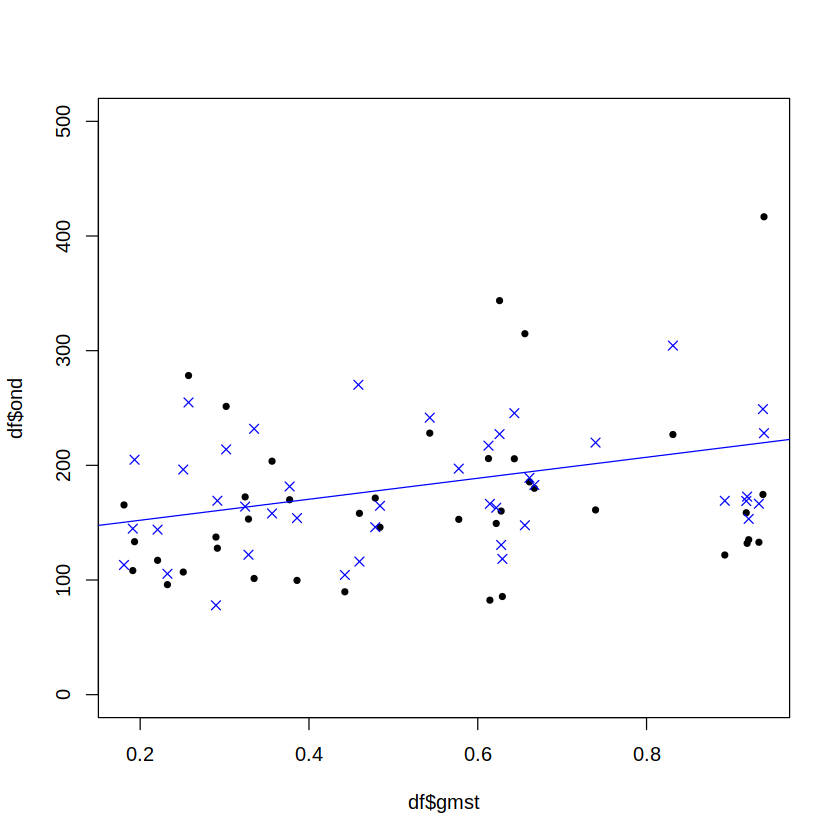

In [6]:
plot(df$gmst, df$ond, pch = 20, ylim = c(0,500))
abline(lm_ond_cts, col = "blue")
points(df$gmst, fitted(lm_ond_cts), pch = 4, col = "blue")

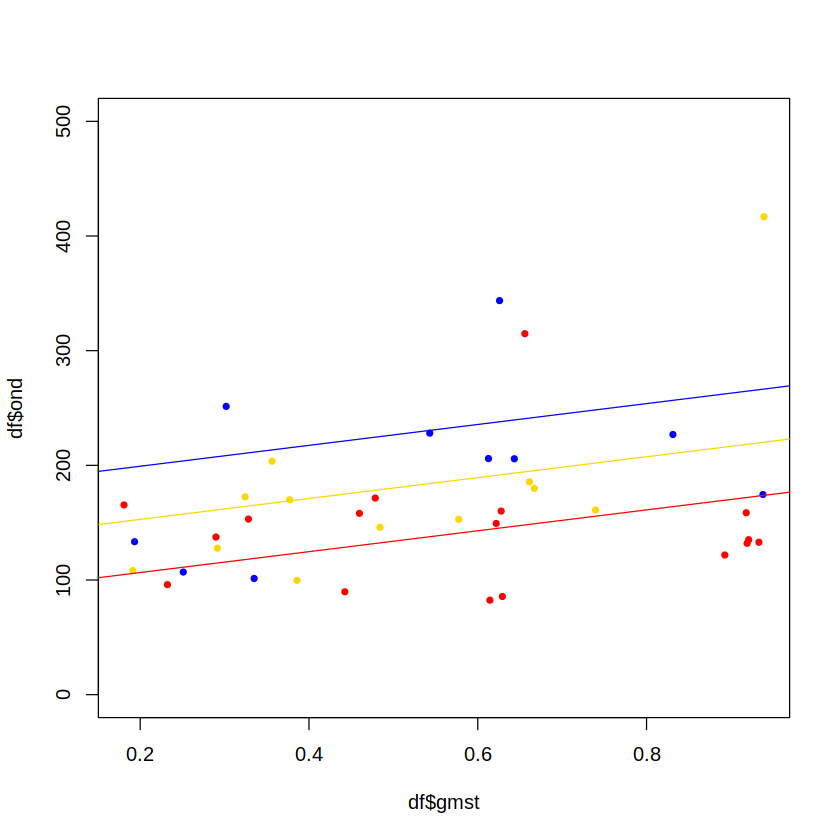

In [213]:
plot(df$gmst, df$ond, pch = 20, ylim = c(0,500), col = c("red", "gold", "blue")[df$nino_ond_bin+2])
abline(sum(lm_ond_bin$coefficients[c(1,3)]), lm_ond_bin$coefficients[2], col = "blue")
abline(lm_ond_bin$coefficients[1], lm_ond_bin$coefficients[2], col = "gold")
abline(diff(lm_ond_bin$coefficients[c(3,1)]), lm_ond_bin$coefficients[2], col = "red")

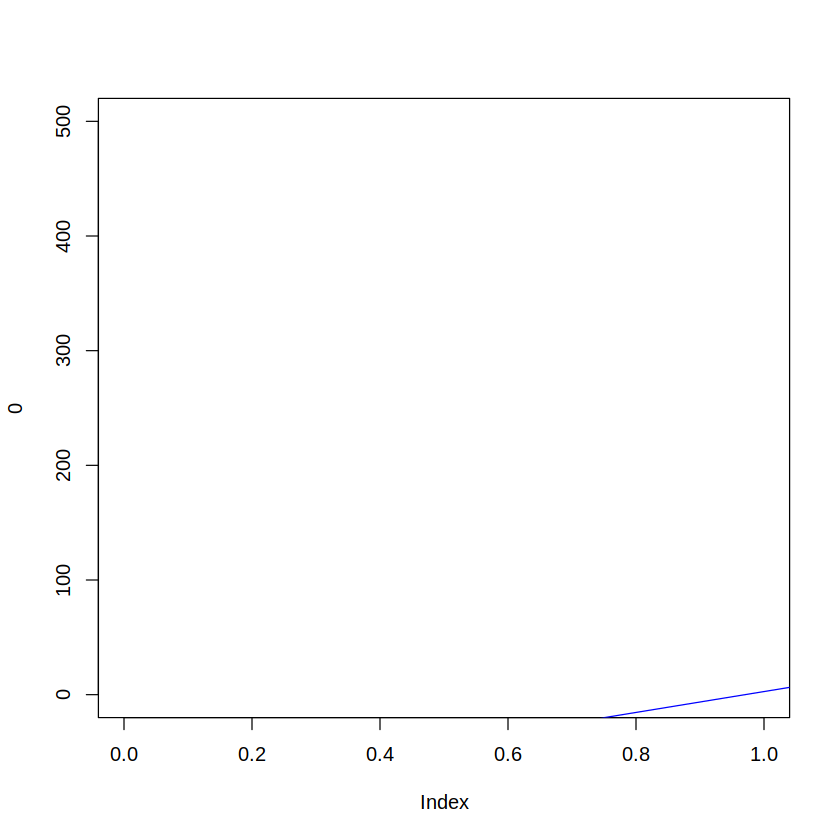

In [207]:
plot(0, type = "n", ylim = c(0,500), xlim = c(0,1))
abline(diff(lm_ond_bin$coefficients[c(1,3)]), lm_ond_bin$coefficients[2], col = "blue")

In [210]:
diff(lm_ond_bin$coefficients[c(3,1)])

(Intercept) 
   88.31881

In [202]:
lm_ond_bin$coefficients[2]

gmst 
91.04799

In [209]:
lm_ond_bin$coefficients[c(1,3)]

(Intercept) nino_ond_bin 
    134.6723      46.3535

## **Choice of distribution**

### **Gamma fitting**

_gamma distribution has fixed coefficient of variation, so shouldn't be necessary to fit location + scale: instead, let rate vary with covariate_

In [1]:
source("../methods_extRemes.r")
df <- read.csv("data/gmst-nino-rains.csv")

In [25]:
# fit all gamma models & check results

invisible(sapply(c("ond", "mam", "pr12", "pr24")[1], function(varnm) {
    
    var_df = df[!is.na(df[varnm]),]
    gamma_init = c(fitdistr(var_df[,varnm], "gamma")$estimate, "alpha" = 0)
    x <- seq(0,1,length.out = nrow(var_df)+2)[2:(nrow(var_df)+1)]
    
    sapply(c("gmst", "nino_ond")[1], function(covnm) {
        if((varnm == "mam") & (covnm == "nino_ond")) covnm = "nino_mam"
        
        mdl <- fgamma(varnm, covnm, var_df)
        
        ns_rate <- mdl$results$par["rate"] + mdl$results$par["alpha"] * var_df[,covnm]
        shape <- mdl$results$par["shape"]
        event_rate <- mdl$results$par["rate"] + mdl$results$par["alpha"] * df[df$year == 2022, covnm]
        
        ts_stationary <- qgamma(pgamma(var_df[,varnm], shape, ns_rate), shape, event_rate)
        x_stationary <- qgamma(x, shape, event_rate)
        
        write.csv(data.frame("x" = x_stationary, "y" = sort(ts_stationary)), paste0("rfit-gamma_",varnm,"_",covnm,".csv"), row.names = F)
    }, simplify = F)
}))